##Google Drive, Imports, and Data Setup

In [ ]:
# Mounting drive so that we can import our dataset into Colab from drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.image as mpimg
from keras import models

In [ ]:
# Setting some parameters, change them if needed
img_height = 180
img_width = 180

In [ ]:
# Make sure you change <folder> to the directory in which your images are stored
data_directory = '/content/drive/MyDrive/CS/faces/boy_girl'

##Train/Test Split and X, y with Directory

In [ ]:
# Defining our training and validation dataset
# 80% of our data will be used to train the model, and 20% will be used for validation
early_stopping_monitor = EarlyStopping(patience=10)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  
  )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  
  )

Found 677 files belonging to 3 classes.
Using 542 files for training.
Found 677 files belonging to 3 classes.
Using 135 files for validation.


##Tuning and Compiling the Model

In [ ]:
# Caching and prefetching data to improve performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Change this based on the number of classes your data conforms to
#num_classes = 2

# Building a neural network
# Rescaling layer that normalizes the data to be between 0 and 1
# Convolutional, pooling, dense layers

# This should be adjusted based on the dataset; the more complex the dataset, the more layers it might require
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

##Running and Plotting the Model

In [ ]:
# Compiling the model
# Can adjust optimizer and loss function if needed

model.compile(
  optimizer='adam',
  loss="binary_crossentropy",
  metrics=['accuracy'])

In [ ]:
# Training the model
# Epochs is the number of iterations, can change that if needed

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=80,
  callbacks = early_stopping_monitor
)

Epoch 1/80
17/17 [==============================] - 63s 2s/step - loss: 0.6220 - accuracy: 0.6771 - val_loss: 0.4244 - val_accuracy: 0.8370
Epoch 2/80
17/17 [==============================] - 1s 86ms/step - loss: 0.3560 - accuracy: 0.8616 - val_loss: 0.3919 - val_accuracy: 0.8667
Epoch 3/80
17/17 [==============================] - 1s 85ms/step - loss: 0.3170 - accuracy: 0.8911 - val_loss: 0.3682 - val_accuracy: 0.8741
Epoch 4/80
17/17 [==============================] - 1s 86ms/step - loss: 0.2744 - accuracy: 0.9059 - val_loss: 0.3177 - val_accuracy: 0.8889
Epoch 5/80
17/17 [==============================] - 1s 86ms/step - loss: 0.2172 - accuracy: 0.9262 - val_loss: 0.3628 - val_accuracy: 0.8741
Epoch 6/80
17/17 [==============================] - 1s 85ms/step - loss: 0.1813 - accuracy: 0.9262 - val_loss: 0.3982 - val_accuracy: 0.8963
Epoch 7/80
17/17 [==============================] - 1s 85ms/step - loss: 0.1498 - accuracy: 0.9262 - val_loss: 0.5187 - val_accuracy: 0.8889
Epoch 8/80
17/

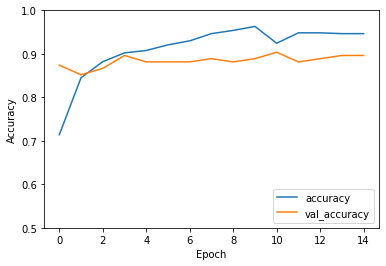

In [ ]:
# Evaluate model
# Plot training and validation accuracy with respect to number of epochs
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

##Taking Test Photo

<IPython.core.display.Javascript object>

Saved to photo.jpg


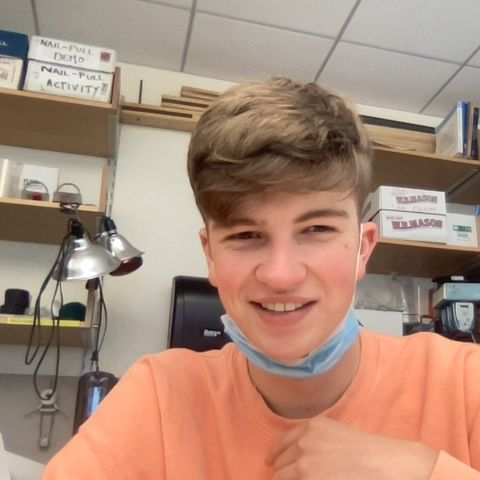

In [ ]:
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = 480;
      canvas.height = 480;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
  
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))



##3 Tests

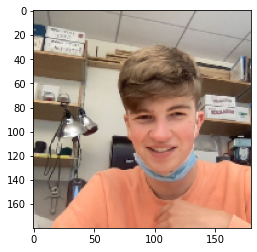

[[1.]]
(1, 180, 180, 3)


In [ ]:
img_path = 'photo.jpg'

img = image.load_img(img_path, target_size=(180, 180, 3))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(model.predict(img_tensor))

print(img_tensor.shape)

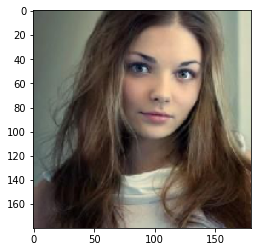

[[1.]]
(1, 180, 180, 3)


In [ ]:
img_path = '/content/drive/MyDrive/CS/faces/boy_girl/test/girl_test.jpg'

img = image.load_img(img_path, target_size=(180, 180, 3))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(model.predict(img_tensor))

print(img_tensor.shape)

##Issues with the model: Long Hair




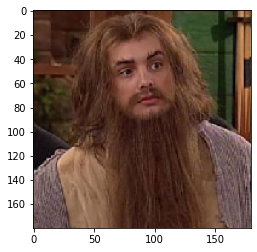

[[1.]]
(1, 180, 180, 3)


In [ ]:
img_path = '/content/drive/MyDrive/CS/faces/boy_girl/test/long_hair_test.jpg'

img = image.load_img(img_path, target_size=(180, 180, 3))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(model.predict(img_tensor))

print(img_tensor.shape)

##Prediction

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)

if classes == 0:
  print("This is a boy")
if classes == 1:
  print("This is a girl")

AttributeError: ignored

##Displaying Conv. Layers


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_input (InputLayer) [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        1846

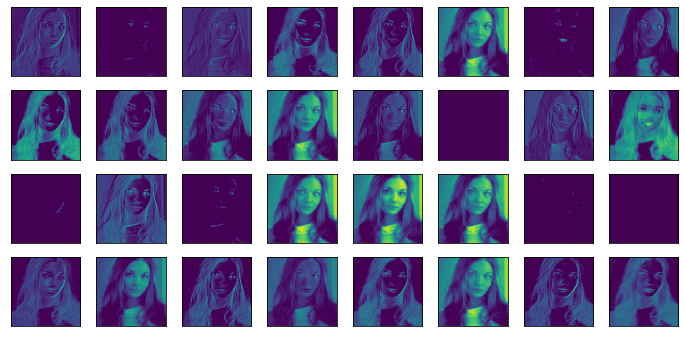

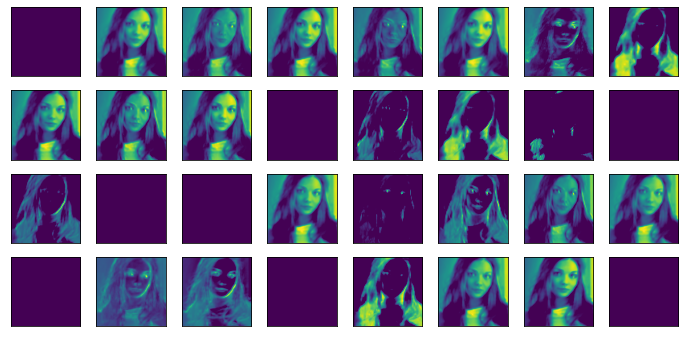

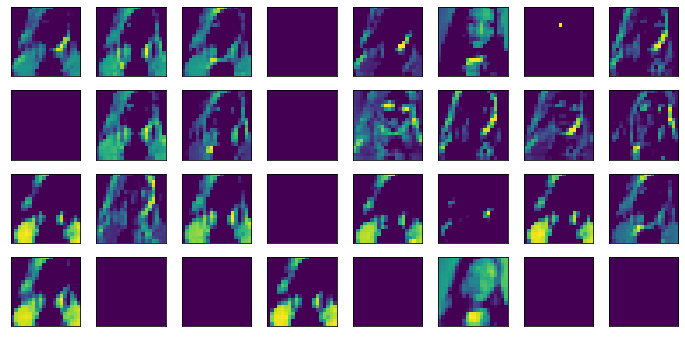

In [ ]:
#Define a new truncated model to only include the conv layers of interest
#conv_layer_index = [1, 3, 6, 8, 11, 13, 15]
from keras.models import Model

conv_layer_index = [1, 3, 6]  #TO define a shorter model
outputs = [model.layers[i].output for i in conv_layer_index]
model_short = Model(inputs=model.inputs, outputs=outputs)
print(model_short.summary())

#Input shape to the model is 180, 180. SO resize input image to this shape.
from keras.preprocessing.image import load_img, img_to_array
img = load_img(img_path, target_size=(180, 180)) #VGG user 180 as input

# convert the image to an array
img = img_to_array(img)
# expand dimensions to match the shape of model input
img = np.expand_dims(img, axis=0)

# Generate feature output by predicting on the input image
feature_output = model_short.predict(img)

columns = 8
rows = 8
for ftr in feature_output:
    #pos = 1
    fig=plt.figure(figsize=(12, 12))
    for i in range(1, 33):
        fig =plt.subplot(rows, columns, i)
        fig.set_xticks([])  #Turn off axis
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :, i-1])
        #pos += 1
    plt.show()